# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from object_detection.eval_util import evaluate_detection_results_pascal_voc

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from utils import label_map_util

from utils import visualization_utils as vis_util

## Object detection imports
Here are the imports from the object detection module.

In [2]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
#MODEL_NAME = 'kitti_frozen'

# Path tofrozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'atrous_frozen_v2/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'kitti_map.pbtxt')

NUM_CLASSES = 9

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
PATH_TO_LABELS = os.path.join('data', 'kitti_map.pbtxt')
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [44]:
with open('kitti_data/train.txt') as f:
    train_ids = f.readlines()[0].split(',')
with open('kitti_data/valid.txt') as f:
    valid_ids = f.readlines()[0].split(',')

In [42]:
len(train_ids)

6732

In [46]:
#len(valid_ids)

# Detection

In [8]:
PATH_TO_TEST_IMAGES_DIR = 'voc_kitti_valid/VOC2012/JPEGImages/'
p = 'voc_kitti_valid/VOC2012/JPEGImages/1023.jpg'
TEST_IMAGE_PATHS = [ p]
FIGSIZE = (20, 20)

In [33]:
def glob_base(pat): return list(map(os.path.basename, glob.glob(pat)))

In [48]:
glob_base('voc_kitti/VOC2012/JPEGImages/*.jpg')[0]

'5393.jpg'

In [62]:
from create_dataset import *

In [65]:
valid_ids = glob_base(VOC_VALID_DIR + '/VOC2012/JPEGImages/*.jpg')
train_ids = glob_base(VOC_TRAIN_DIR+ '/VOC2012/JPEGImages/*.jpg')

len(pd.Index(valid_ids).intersection(train_ids))

0

In [50]:
glob_base('voc_kitti_valid/VOC2012/JPEGImages/*.jpg')[0]

'3528.jpg'

### Hack to overcome not deleting voc_kitti_valid

In [60]:
def glob_base(pat): return list(map(os.path.basename, glob.glob(pat)))
assert len(pd.Index(
   glob_base('voc_kitti_valid/VOC2012/JPEGImages/*.jpg')
).difference(glob_base('voc_kitti/VOC2012/JPEGImages/*.jpg'))) < 750

749

In [56]:
test_dir = 'voc_kitti_valid/VOC2012/JPEGImages/'
test_image_paths = [os.path.join(test_dir, x) for x in allowed_valid_ids]

In [57]:
len(test_image_paths)

320

In [10]:
from utils.np_box_list import BoxList

In [11]:
image_path = paths[0]

In [12]:
from create_dataset import xml_to_dict

In [13]:
def get_annotations(image_path):
    img_id = os.path.basename(image_path)[:-4]
    annotation_path = os.path.join(
    os.path.split(os.path.dirname(image_path))[0], 'Annotations',
    '{}.xml'.format(img_id)
    )
    return xml_to_dict(annotation_path)

In [14]:
#data = get_annotations(image_path)

In [14]:
from utils.kitti import show_groundtruth, create_results_list

In [ ]:
!wc kitti_data/train.txt.txt

In [ ]:
ls kitti_data/valid/image_2/ | wc

In [15]:
train_labs= glob.glob('kitti_data/training/label_2/*.txt')
test_labs = glob.glob('kitti_data/valid/label_2/*.txt')

In [22]:
len(test_labs)

749

In [23]:
len(train_labs)

6732

In [ ]:
lns

In [ ]:
# n/A 80%
# also wrong enough that maybe a bug?

In [18]:
def get_boxes_scores_classes(image_np, sess, detection_graph):
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result immage, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    return boxes, scores, classes, num_detections

In [19]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    boxes, scores, classes, num_detections = get_boxes_scores_classes(image_np, sess, detection_graph)
    print(boxes[0][0])
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

3490

In [58]:
%%time
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        res = create_results_list(test_image_paths, sess, detection_graph)

CPU times: user 2min 7s, sys: 12.6 s, total: 2min 19s
Wall time: 3min 25s


In [59]:
import pandas as pd
pd.Series(evaluate_detection_results_pascal_voc(res, categories))

/home/shleifer/object_detection_kitti/object_detection/utils/metrics.py:145: RuntimeWarning: invalid value encountered in true_divide
  num_images_correctly_detected_per_class / num_gt_imgs_per_class)


PerformanceByCategory/mAP@0.5IOU/car               0.962958
PerformanceByCategory/mAP@0.5IOU/cyclist           0.848411
PerformanceByCategory/mAP@0.5IOU/dontcare          0.351580
PerformanceByCategory/mAP@0.5IOU/misc              0.813007
PerformanceByCategory/mAP@0.5IOU/pedestrian        0.800924
PerformanceByCategory/mAP@0.5IOU/person_sitting    0.694118
PerformanceByCategory/mAP@0.5IOU/tram              0.961799
PerformanceByCategory/mAP@0.5IOU/truck             0.975472
PerformanceByCategory/mAP@0.5IOU/van               0.950256
Precision/mAP@0.5IOU                               0.817614
dtype: float64

In [21]:
import pandas as pd
pd.Series(evaluate_detection_results_pascal_voc(res, categories))

/home/shleifer/object_detection_kitti/object_detection/utils/metrics.py:145: RuntimeWarning: invalid value encountered in true_divide
  num_images_correctly_detected_per_class / num_gt_imgs_per_class)


PerformanceByCategory/mAP@0.5IOU/car               0.970971
PerformanceByCategory/mAP@0.5IOU/cyclist           0.829376
PerformanceByCategory/mAP@0.5IOU/dontcare          0.532729
PerformanceByCategory/mAP@0.5IOU/misc              0.986111
PerformanceByCategory/mAP@0.5IOU/pedestrian        0.820800
PerformanceByCategory/mAP@0.5IOU/person_sitting    0.744444
PerformanceByCategory/mAP@0.5IOU/tram              1.000000
PerformanceByCategory/mAP@0.5IOU/truck             1.000000
PerformanceByCategory/mAP@0.5IOU/van               0.945438
Precision/mAP@0.5IOU                               0.869985
dtype: float64

In [68]:
len(test_image_paths)

320

In [69]:
320/ 7491

0.04271792818048325

[ 0.49856016  0.57383096  0.75304139  0.68100977]
(13, 4)


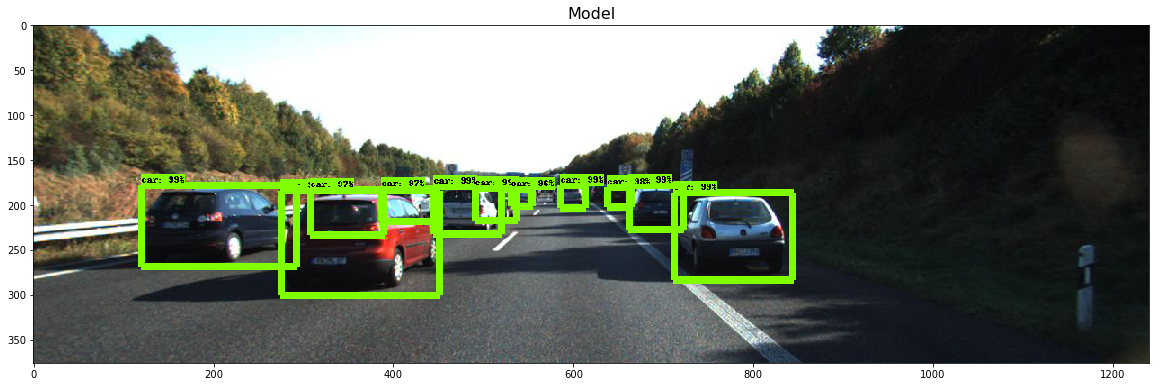

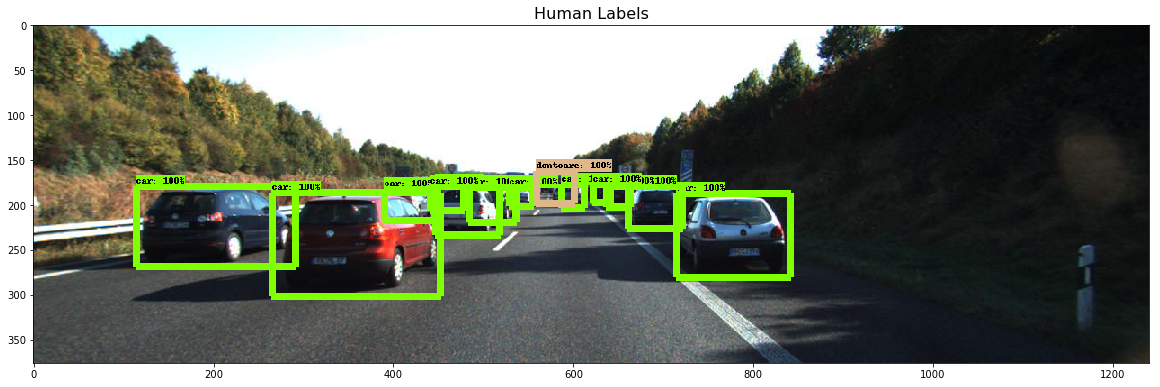

In [67]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_path = np.random.choice(test_image_paths)
        image = Image.open(image_path)
        image_np = load_image_into_numpy_array(image)
        boxes, scores, classes, num_detections = get_boxes_scores_classes(image_np, sess, detection_graph)
        image_process = detect_objects(image_np, sess, detection_graph)
        # [x['name'] for x in data['object']]
        plt.figure(figsize=FIGSIZE)
        plt.imshow(image_process)
        plt.title('Model', fontsize=16)
        plt.figure(figsize=FIGSIZE)
        plt.imshow(show_groundtruth(image_path))
        plt.title('Human Labels', fontsize=16)

In [ ]:
label_paths = glob.glob(os.path.join('kitti_data', '*','label_2', '*.txt'))

In [ ]:

#label_paths

In [ ]:
for path in label_paths:
    strip_leading_zeroes(path)

In [ ]:
from_kitti = {'image': {'path': 'kitti_data/training/image_2/2456.jpg', 'height': 370, 'segmented_path': None, 'id': '2456', 'width': 1224}, 'detections': [{'top': 136.7, 'left': 275.0, 'right': 353.9, 'bottom': 299.54, 'label': 'person'}]}

In [ ]:
from create_pascal_tf_record import kitti_dict_to_tf_example

In [ ]:
kitti_dict_to_tf_example(from_kitti)

In [ ]:
#create_records()

### Kitti Port

In [ ]:
import glob
images = glob.glob('/Users/shleifer/kitti_trunc/training/image_2/*')


In [ ]:
labels = glob.glob('/Users/shleifer/kitti_trunc/training/label_2/*')

In [ ]:
dets = glob.glob('/Users/shleifer/kitti_trunc/training/det_2/*')

In [ ]:
orig_image_paths = glob.glob('/Users/shleifer/kitti_data/training/image_2/*.png')

In [ ]:
from create_dataset import convert_to_jpg_and_save
%load_ext autoreload
%autoreload 2

In [ ]:
def convert_to_jpg_and_save(png_path):
    im = Image.open(png_path)
    rgb_im = im.convert('RGB')
    new_path = '{}.jpg'.format(png_path[:-4])
    rgb_im.save(new_path)
    return new_path
Image.open(convert_to_jpg_and_save(orig_image_paths[0]))

In [ ]:
import shutil

In [ ]:
import pandas as pd
pd.value_counts(list(map(lambda x: len(os.path.basename(x)),images)))

In [ ]:
Image.open(images[0])

In [ ]:
root_dir = '/Users/shleifer/voc_kitti/VOC2012/'
img_dir = os.path.join(root_dir, 'JPEGImages')
ann_dir = os.path.join(root_dir, 'Annotations')
set_dir = os.path.join(root_dir, 'ImageSets', 'Main')

In [ ]:
labels = glob.glob('/Users/shleifer/kitti_trunc/training/label_2/*')

In [ ]:
xml_p = glob.glob('/Users/shleifer/voc_kitti/VOC2012/Annotations/1023.xml')[0]

In [ ]:
voc_annot = tf.gfile.GFile(xml_p, 'r').read()

In [ ]:
%load_ext autoreload
%autoreload 2
from create_pascal_tf_record import dict_to_tf_example

In [ ]:
import sys; sys.path.append('..')

In [ ]:
from object_detection.create_pascal_tf_record import dict_to_tf_example

In [ ]:
dataset_directory =  '/Users/shleifer/voc_kitti/'
image_subdirectory='JPEGImages'

In [ ]:
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
import hashlib
import io
import logging
import os

from lxml import etree
import PIL.Image
import tensorflow as tf


writer = tf.python_io.TFRecordWriter('data/train.tfrecord')
label_map_dict = label_map_util.get_label_map_dict('data/my_map.pbtxt')
annotations_dir = '/Users/shleifer/voc_kitti/VOC2012/Annotations/'
examples_path = '/Users/shleifer/voc_kitti/VOC2012/ImageSets/Main/trainval.txt'


examples_path = '/Users/shleifer/voc_kitti/VOC2012/ImageSets/Main/trainval.txt'

#examples_list

def create_records(examples_path):
    examples_list = dataset_util.read_examples_list(examples_path)
    for example in examples_list[1:11]:
        path = os.path.join(annotations_dir, example + '.xml')
        #print(path)
        with tf.gfile.GFile(path, 'r') as fid:
            xml_str = fid.read()
        xml = etree.fromstring(xml_str)
        data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']
        tf_example = dict_to_tf_example(data, 
                                        dataset_directory,
                                        label_map_dict,
                                        False)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [ ]:
create_records(examples_path)

In [ ]:
data['folder']

In [ ]:
os.path.join('/Users/shleifer/voc_kitti/VOC2012/JPEGImages/')

In [ ]:
data['filename']

In [ ]:
f = 'data/train.tfrecord'
for serialized_example in tf.python_i o.tf_record_iterator(f):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    print(example)
    break

    # Read data in specified format
    label = example.features.feature["image/object/class/label"].float_list.value
    ids = example.features.feature["ids"].int64_list.value
    values = example.features.feature["values"].float_list.value
    print(label, id, values)

In [ ]:
example.features.feature.keys()

In [ ]:
Image.open('/Users/shleifer/voc_kitti/VOC2012/JPEGImages/5308.jpg')

In [ ]:
ls data/train.tfrecord

In [ ]:
#examples_list

In [ ]:
label_map_dict

In [ ]:
data['object']

In [ ]:
#full_path

In [ ]:
  with tf.gfile.GFile(full_path, 'rb') as fid:
    encoded_jpg = fid.read()

In [ ]:
import io
encoded_jpg

In [ ]:
from cv2 import imread

In [ ]:
import io

In [ ]:
img_path = os.path.join(data['folder'], image_subdirectory, data['filename'])
full_path = os.path.join(dataset_directory, img_path)

In [ ]:
data['folder']

In [ ]:
/Users/shleifer/voc_kitti/VOC2012/JPEGImages/

In [ ]:
data

In [ ]:
dict_to_tf_example()

In [ ]:
examples_path = '~/sh'

In [ ]:
ls data

In [ ]:
!cat {labels[0]}

In [ ]:
# list image sets
all_files = !ls {set_dir}
image_sets = sorted(list(set([filename.replace('.txt', '').strip().split('_')[0] for filename in all_files])))
image_sets

In [ ]:
ann_dir